In [ ]:
from turtle import width
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [ ]:
df=pd.read_csv(f'C:/Users/lenovo/Desktop/Nature Food-SSB_consumption/高温天气含糖饮料摄入分析/project_05_01/processed_data/chain_store_data/cities.csv',parse_dates=['dt'],index_col=['dt'])
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df=df[df['MAX']>=21]
df=df.dropna()
beijing=df[(df['city']=='beijing')]['2019-05-21':'2019-09-16']
xian=df[(df['city'] =='xian')]['2019-05-21':'2019-09-09']
changsha=df[(df['city'] =='changsha')]['2019-05-22':'2019-10-10']
shenzhen=df[(df['city'] =='shenzhen')]['2019-03-26':'2019-11-27']
beijing['num_dessert']=beijing['num_dessert']/beijing['num_dessert'].max()
xian['num_dessert']=xian['num_dessert']/xian['num_dessert'].max()
changsha['num_dessert']=changsha['num_dessert']/changsha['num_dessert'].max()
shenzhen['num_dessert']=shenzhen['num_dessert']/shenzhen['num_dessert'].max()
beijing['sugar_weight']=beijing['sugar_weight']*100/18608.74448
xian['sugar_weight']=xian['sugar_weight']*100/11909.35212
changsha['sugar_weight']=changsha['sugar_weight']*100/17295.15878
shenzhen['sugar_weight']=shenzhen['sugar_weight']*100/15913.843839999998
df = pd.concat([beijing,xian,changsha,shenzhen])
df['MAX']=df['MAX']-22
NUM_BINS=8
col=['RH','num_dessert','WDSP','PRCP']
def normalize(X):
    return X/X.max()
df[col]=df[col].apply(normalize)
dic={}
for i in col:
    dic[i+'_min']=df[i].min()
    dic[i+'_max']=df[i].max()
    interval=(df[i].max()-df[i].min())/(NUM_BINS-1)
    dic[i+'_bins']=np.arange(df[i].min(),df[i].max()+1.5*interval,interval).tolist()
df['RH_cut'] = pd.cut(df['RH'], bins=dic['RH_bins'], labels=range(0, NUM_BINS),right=False).astype(int)
df['num_dessert_cut'] = pd.cut(df['num_dessert'], bins=dic['num_dessert_bins'], labels=range(0,NUM_BINS),right=False).astype(int)
df['WDSP_cut'] = pd.cut(df['WDSP'], bins=dic['WDSP_bins'], labels=range(0, NUM_BINS),right=False).astype(int)
df['PRCP_cut'] = pd.cut(df['PRCP'], bins=dic['PRCP_bins'], labels=range(0, NUM_BINS),right=False).astype(int)

In [7]:
hlm = smf.mixedlm('sugar_weight ~ MAX+RH_cut+PRCP_cut+WDSP_cut+num_dessert_cut+C(week_dt)', df, groups=df["city"],re_formula="1+MAX")#, 
hlmf = hlm.fit()
y_fitted = hlmf.fittedvalues
print(hlmf.summary())
random_effects = hlmf.random_effects
for k,v in random_effects.items():
    print(k,':\n',v)
X = df[['MAX','RH_cut','num_dessert_cut','WDSP_cut','PRCP_cut']]
print('MAX VIF:',variance_inflation_factor(X.values, 0))
day_of_week =0
for i in ['Mon', 'Tues', 'Wed', 'Thur', 'Sat', 'Sun']:
    day_of_week+=hlmf.params[f'C(week_dt)[T.{i}]']
day_of_week=day_of_week/6
substitution_mean=df['num_dessert_cut'].mean()
RH_mean=df['RH_cut'].mean()
WDSP_mean= df['WDSP_cut'].mean()
PRCP_mean=df['PRCP_cut'].mean()
MAX_data=(df['MAX']*hlmf.params['MAX']+RH_mean*hlmf.params['RH_cut']+
          hlmf.params['num_dessert_cut']*substitution_mean+hlmf.params['Intercept']+
          PRCP_mean*hlmf.params['PRCP_cut']+WDSP_mean*hlmf.params['WDSP_cut']+
          day_of_week
          )


             Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   sugar_weight
No. Observations:   585       Method:               REML        
No. Groups:         4         Scale:                329.3199    
Min. group size:    104       Log-Likelihood:       -2513.6655  
Max. group size:    238       Converged:            Yes         
Mean group size:    146.2                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          108.306    5.235 20.687 0.000  98.044 118.567
C(week_dt)[T.Mon]  -22.628    2.805 -8.067 0.000 -28.126 -17.131
C(week_dt)[T.Sat]   -2.449    2.845 -0.861 0.389  -8.025   3.127
C(week_dt)[T.Sun]   -7.696    2.821 -2.728 0.006 -13.225  -2.167
C(week_dt)[T.Thur]  -7.353    2.786 -2.639 0.008 -12.813  -1.893
C(week_dt)[T.Tues] -17.913    2.807 -6.

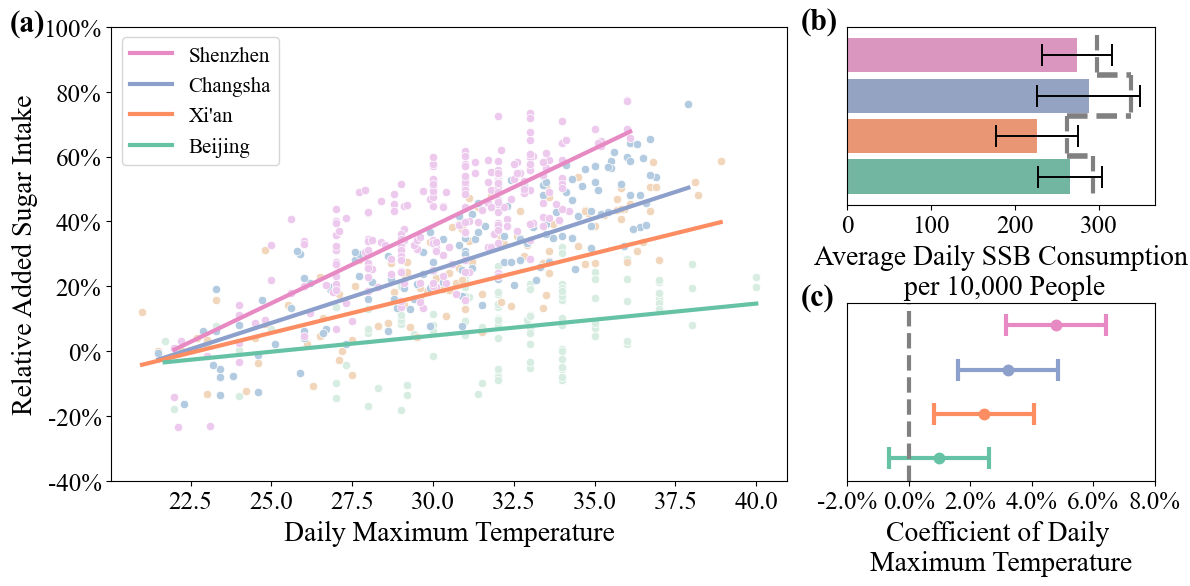

In [ ]:
label_fontsize=20
ticks_fontsize=18
legend_fontsize=15
colors = sns.color_palette("YlOrBr",3)  #GnBu,YlOrBr
COLOR_LIST = sns.color_palette("Set2")
color_list =[]
for i in range(4):
    base_color = COLOR_LIST[0]  
    lighter_color = sns.light_palette(base_color, 6)
    color_list.append(lighter_color[4])

plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 6))

plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
plt.gca().text(-0.15, 1.035, '(a)', transform=plt.gca().transAxes, fontsize=22, va='top', fontweight='bold')
#**********************************************************************************#
out=(y_fitted-100).tolist()
beijing_in=df.loc[df['city']=='beijing','MAX']
beijing_out=out[0:len(beijing)]
beijing_line=(beijing_in*(hlmf.params['MAX']+random_effects['beijing']['MAX'])+RH_mean*hlmf.params['RH_cut']+
          hlmf.params['num_dessert_cut']*substitution_mean+hlmf.params['Intercept']+
          PRCP_mean*hlmf.params['PRCP_cut']+WDSP_mean*hlmf.params['WDSP_cut']+
          day_of_week+random_effects['beijing']['Group']
          )
xian_in=df.loc[df['city']=='xian','MAX']
xian_out=out[len(beijing):len(beijing)+len(xian)]
xian_line=(xian_in*(hlmf.params['MAX']+random_effects['xian']['MAX'])+RH_mean*hlmf.params['RH_cut']+
          hlmf.params['num_dessert_cut']*substitution_mean+hlmf.params['Intercept']+
          PRCP_mean*hlmf.params['PRCP_cut']+WDSP_mean*hlmf.params['WDSP_cut']+
          day_of_week+random_effects['xian']['Group']
          )
changsha_in=df.loc[df['city']=='changsha','MAX']
changsha_out=out[len(beijing)+len(xian):len(beijing)+len(xian)+len(changsha)]
changsha_line=(changsha_in*(hlmf.params['MAX']+random_effects['changsha']['MAX'])+RH_mean*hlmf.params['RH_cut']+
          hlmf.params['num_dessert_cut']*substitution_mean+hlmf.params['Intercept']+
          PRCP_mean*hlmf.params['PRCP_cut']+WDSP_mean*hlmf.params['WDSP_cut']+
          day_of_week+random_effects['changsha']['Group']
          )
shenzhen_in=df.loc[df['city']=='shenzhen','MAX']
shenzhen_out=out[len(beijing)+len(xian)+len(changsha):len(shenzhen)+len(beijing)+len(xian)+len(changsha)]
shenzhen_line=(shenzhen_in*(hlmf.params['MAX']+random_effects['shenzhen']['MAX'])+RH_mean*hlmf.params['RH_cut']+
          hlmf.params['num_dessert_cut']*substitution_mean+hlmf.params['Intercept']+
          PRCP_mean*hlmf.params['PRCP_cut']+WDSP_mean*hlmf.params['WDSP_cut']+
          day_of_week+random_effects['shenzhen']['Group']
          )
sns.scatterplot(x=beijing_in+22, y=beijing_out,color='#D8EDE2')
sns.scatterplot(x=xian_in+22, y=xian_out,color='#F1D6BB')
sns.scatterplot(x=changsha_in+22, y=changsha_out,color='#B3CBE0')
sns.scatterplot(x=shenzhen_in+22, y=shenzhen_out, color='#EDC9EE')
sns.lineplot(x=shenzhen_in+22,y=shenzhen_line-100,label='Shenzhen',color=COLOR_LIST[3],linewidth=3)
sns.lineplot(x=changsha_in+22,y=changsha_line-100, label='Changsha',color=COLOR_LIST[2],linewidth=3)
sns.lineplot(x=xian_in+22,y=xian_line-100, label='Xi\'an',color=COLOR_LIST[1],linewidth=3)
sns.lineplot(x=beijing_in+22,y=beijing_line-100, label='Beijing',color=COLOR_LIST[0],linewidth=3)
plt.xlabel('Daily Maximum Temperature',fontsize=label_fontsize)
plt.ylabel('Relative Added Sugar Intake',fontsize=label_fontsize)
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
yticks = plt.yticks()
new_y_labels = [f"{int(ytick)}%" for ytick in yticks[0]]
plt.yticks(yticks[0], new_y_labels)
plt.legend(fontsize=legend_fontsize)
plt.tight_layout()




plt.subplot2grid((2, 3), (1, 2),colspan=1)
plt.gca().text(-0.15, 1.1, '(c)', transform=plt.gca().transAxes, fontsize=22, va='top', fontweight='bold')
#**********************************************************************************#
groups = ['beijing', 'xian', 'changsha', 'shenzhen']
COLOR = sns.color_palette("Set2")
# 创建画布并设置背景颜色
for j, i in enumerate(groups):
    dy_low, dy_high = hlmf.conf_int().loc['MAX']
    dy = (dy_high - dy_low) / 2
    plt.errorbar( hlmf.params['MAX'] + hlmf.random_effects[i]['MAX'],i, xerr=dy, fmt='.', markersize=15,
                 ecolor=COLOR[j], color=COLOR[j], elinewidth=3, capsize=8, capthick=3)
plt.ylim(-0.5, len(groups)-0.5)
plt.xlim(-0.5, 6.4)
plt.yticks(fontsize=ticks_fontsize)
plt.yticks([])
plt.xticks(fontsize=ticks_fontsize)
# 设置 x 轴的主要刻度间隔
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=4))
plt.xlim(-0.5, 6.4)
xticks = plt.xticks()
new_y_labels = [f"{(xtick)}%" for xtick in xticks[0]]
plt.xticks(xticks[0], new_y_labels)
plt.xlabel('Coefficient of Daily \nMaximum Temperature',fontsize=label_fontsize)
plt.axvline(x=0, linestyle='--', color='gray', linewidth=3)
plt.tight_layout()
beijing_data=pd.read_parquet("C:/Users/lenovo/Desktop/Nature Food-SSB_consumption/高温天气含糖饮料摄入分析/高温天气糖分摄入回归/processed_data/chain_store_data/beijing_naicha.parquet")
beijing_data['city']='beijing'
xian_data=pd.read_parquet("C:/Users/lenovo/Desktop/Nature Food-SSB_consumption/高温天气含糖饮料摄入分析/高温天气糖分摄入回归/processed_data/chain_store_data/xian_naicha.parquet")
xian_data['city']='xian'
changsha_data=pd.read_parquet("C:/Users/lenovo/Desktop/Nature Food-SSB_consumption/高温天气含糖饮料摄入分析/高温天气糖分摄入回归/processed_data/chain_store_data/changsha_naicha.parquet")
changsha_data['city']='changsha'
shenzhen_data=pd.read_parquet("C:/Users/lenovo/Desktop/Nature Food-SSB_consumption/高温天气含糖饮料摄入分析/高温天气糖分摄入回归/processed_data/chain_store_data/shenzhen_naicha.parquet")
shenzhen_data['city']='shenzhen'
user=beijing_data['user_id'].unique()
beijing_data=beijing_data[(beijing_data['dt']>= '2019-05-22')&(beijing_data['dt']<= '2019-09-09')]
beijing_data=beijing_data.groupby('dt')['cnt'].sum().reset_index()
beijing_data['cnt']=beijing_data['cnt']/len(user)*10000
user=xian_data['user_id'].unique()
xian_data=xian_data[(xian_data['dt']>= '2019-05-22')&(xian_data['dt']<= '2019-09-09')]
xian_data=xian_data.groupby('dt')['cnt'].sum().reset_index()
xian_data['cnt']=xian_data['cnt']/len(user)*10000
user=changsha_data['user_id'].unique()
changsha_data=changsha_data[(changsha_data['dt']>= '2019-05-22')&(changsha_data['dt']<= '2019-09-09')]
changsha_data=changsha_data.groupby('dt')['cnt'].sum().reset_index()
changsha_data['cnt']=changsha_data['cnt']/len(user)*10000
user=shenzhen_data['user_id'].unique()
shenzhen_data=shenzhen_data[(shenzhen_data['dt']>= '2019-05-22')&(shenzhen_data['dt']<= '2019-09-09')]
shenzhen_data=shenzhen_data.groupby('dt')['cnt'].sum().reset_index()
shenzhen_data['cnt']=shenzhen_data['cnt']/len(user)*10000
beijing_data['city']='beijing'
xian_data['city']='xian'
changsha_data['city']='changsha'
shenzhen_data['city']='shenzhen'
df=pd.concat([beijing_data,xian_data,changsha_data,shenzhen_data])




COLOR = sns.color_palette("Set2")
ax=plt.subplot2grid((2, 3), (0, 2),colspan=1)
plt.gca().text(-0.15, 1.1, '(b)', transform=plt.gca().transAxes, fontsize=22, va='top', fontweight='bold')
city_stats = df.groupby('city')['cnt'].agg(['mean', 'std']).reset_index()
city_colors = {
    'beijing': COLOR[0],
    'xian': COLOR[1],
    'changsha': COLOR[2],
    'shenzhen': COLOR[3]
}
city_order = ['beijing', 'xian', 'changsha', 'shenzhen']
bar_plot = sns.barplot(x='mean', y='city', data=city_stats, palette=city_colors, width=0.85, order=city_order[::-1])
city_stats['city'] = pd.Categorical(city_stats['city'], categories=city_order[::-1], ordered=True)
city_stats = city_stats.sort_values('city')
for index, row in city_stats.iterrows():
    plt.errorbar(row['mean'], row['city'], xerr=row['std'], fmt='none', c='black', capsize=8, elinewidth=1.4,capthick=1.4)
plt.ylabel('',fontsize=label_fontsize)
plt.yticks([])
plt.xticks(fontsize=ticks_fontsize)
plt.xlabel('Average Daily SSB Consumption\n per 10,000 People',fontsize=label_fontsize)
plt.tick_params(axis='x', which='both', bottom=True, top=False) 
city_refer={
    'beijing':293.1602402635148 ,
    'xian': 261.55420132556384,
    'changsha':337.53744285038624,
    'shenzhen': 297.78036982400766    
}
for i, j in enumerate(city_order[::-1]):
    if i == 0:
        plt.plot( [city_refer[j], city_refer[j]],[i-0.5, i+0.5], color="gray", linestyle="--", linewidth=3,label='saturation')
    elif (i != 0 ):
        plt.plot( [city_refer[j], city_refer[j]],[i-0.5, i+0.5], color="gray", linestyle="--", linewidth=3)
        plt.plot( [min(city_refer[k],city_refer[j]), max(city_refer[k],city_refer[j])],[i-0.5, i-0.5], color="gray", linestyle="--", linewidth=4)
    k=j
ax.grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
ax.xaxis.set_major_locator(MultipleLocator(100))
plt.tight_layout()
plt.subplots_adjust(hspace=0.55)
plt.show()